In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import streamlit as st
# ‚úÖ Í∞ÄÏû• Î®ºÏ†Ä ÌéòÏù¥ÏßÄ ÏÑ§Ï†ï
st.set_page_config(page_title="CPI ÏòàÏ∏° ÎåÄÏãúÎ≥¥Îìú", layout="wide")
import seaborn as sns
from streamlit_pandas_profiling import st_profile_report
from ydata_profiling import ProfileReport

2025-03-25 17:15:33.860 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
c:\test\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Ìè∞Ìä∏ÏßÄÏ†ï
plt.rcParams['font.family'] = 'Malgun Gothic'




# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏ Íπ®Ïßê ÏßÄÏ†ï
plt.rcParams['axes.unicode_minus'] = False




# Ïà´ÏûêÍ∞Ä ÏßÄÏàòÌëúÌòÑÏãùÏúºÎ°ú ÎÇòÏò¨ Îïå ÏßÄÏ†ï
pd.options.display.float_format = '{:.2f}'.format


In [6]:
# 1. ÌååÏùº Í≤ΩÎ°ú Î∞è Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
file_cpi = "dataset/cpi.csv" # ÏÜåÎπÑÏûê Î¨ºÍ∞ÄÏßÄÏàò
file_rate = "dataset/interest_rate.csv" # Í∏∞Ï§ÄÍ∏àÎ¶¨
file_ex = "dataset/exchange_rate.csv" # ÌôòÏú®
# encoding="CP949": ÌïúÍ∏ÄÏù¥ Ìè¨Ìï®Îêú ÌååÏùºÏùº Í≤ΩÏö∞ CP949 Ïù∏ÏΩîÎî©
# skiprows=2    ÌååÏùº ÏÉÅÎã®Ïùò ÏÑ§Î™ÖÏù¥ÎÇò Î∂àÌïÑÏöîÌïú Ìñâ(Ïòà: Ï∂úÏ≤ò, Îã®ÏúÑ Îì±) 2Ï§ÑÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.
cpi_raw = pd.read_csv(file_cpi, encoding="CP949", skiprows=2)
rate_raw = pd.read_csv(file_rate, encoding="CP949", skiprows=2)
ex_raw = pd.read_csv(file_ex, encoding="CP949", skiprows=2)

In [7]:
# 2. CPI Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Î≥ÄÍ≤ΩÌïòÏßÄ ÏïäÍ≥† ÏïàÏ†ÑÌïòÍ≤å ÏûëÏóÖ
cpi_data = cpi_raw.copy()
cpi_data.rename(columns={"Unnamed: 0": "ÎÇ†Ïßú"}, inplace=True)
# Ï≤´ Î≤àÏß∏ Ìñâ(Ïù∏Îç±Ïä§ 0)Ïóê Ïª¨Îüº Ïù¥Î¶ÑÏù¥ Ìïú Î≤à Îçî Îì§Ïñ¥Í∞Ä ÏûàÎäî Í≤ΩÏö∞
# .reset_index(drop=True) : Ï§Ñ Î≤àÌò∏Î•º Ï≤òÏùåÎ∂ÄÌÑ∞ Îã§Ïãú Ï†ïÎ¶¨
# drop=True: ÏõêÎûò Î≤àÌò∏(3Î≤à, 4Î≤à, 5Î≤à)Î•º Í∏∞Ïñµ Ïïà Ìï¥ÎèÑ ÎèºÏöî
# ÎßåÏïΩ drop=FalseÎ°ú ÌïòÎ©¥ Ïù¥Î†áÍ≤å ÏòõÎÇ† Î≤àÌò∏ÎèÑ Í∞ôÏù¥ Î≥¥Ïó¨Ï§òÏöî
cpi_data = cpi_data[1:].reset_index(drop=True)
# ÎÇ†ÏßúÎùºÎäî Ïó¥ÏóêÏÑú "Ïõî"Ïù¥ÎùºÎäî Í∏ÄÏûêÎ•º ÏóÜÏï†Îäî ÏΩîÎìú
# .astype(str) :  ÎÇ†ÏßúÍ∞Ä Ïà´ÏûêÎ°ú ÎêòÏñ¥ ÏûàÏúºÎ©¥, **Í∏ÄÏûê(Î¨∏Ïûê)**Î°ú Î∞îÍøîÏ£ºÎäî Í±∞ÏòàÏöî.
#  .str.replace("Ïõî", "", regex=False): "Ïõî"Ïù¥ÎùºÎäî Í∏ÄÏûêÎ•º ÎπàÏπ∏("")ÏúºÎ°ú Î∞îÍæ∏Îäî Í±∞ÏòàÏöî.
# regex=FalseÎäî ‚ÄúÏ†ïÍ∑úÌëúÌòÑÏãù‚ÄùÏù¥ÎùºÎäî Î≥µÏû°Ìïú Í±∏ Ïïà Ïì∞Í≥† Í∑∏ÎåÄÎ°ú Î¨∏ÏûêÎßå Ï∞æÍ≤†Îã§Îäî ÎúªÏù¥ÏóêÏöî.
cpi_data["ÎÇ†Ïßú"] = cpi_data["ÎÇ†Ïßú"].astype(str).str.replace("Ïõî", "", regex=False)
# "ÎÇ†Ïßú"ÎùºÎäî Ïó¥Ïóê Îã§Î•∏ ÎÇ¥Ïö©ÎèÑ ÏûàÏùå
# Ïà´Ïûê 6ÏûêÎ¶¨Îßå ÎÇ®Í∏∞Í≥† Ïã∂Ïùå
# ^ Î¨∏ÏûêÏó¥Ïùò ÏãúÏûë/\d  Ïà´Ïûê 1Í∞ú/{6}   Ïà´ÏûêÍ∞Ä 6Í∞ú Ïó∞ÏÜç/$ Î¨∏ÏûêÏó¥Ïùò ÎÅù
#  Ï¶â, "Ï≤òÏùåÎ∂ÄÌÑ∞ ÎÅùÍπåÏßÄ Ïà´Ïûê 6Í∞úÎßå ÏûàÏñ¥Ïïº ÌïúÎã§!" Îäî Îúª
cpi_data = cpi_data[cpi_data["ÎÇ†Ïßú"].str.match(r"^\d{6}$")]
# "200001" Í∞ôÏùÄ Ïà´Ïûê Î¨∏ÏûêÏó¥ÏùÑ, ÏßÑÏßú ÎÇ†ÏßúÎ°ú Î∞îÍæ∏Îäî Í≤É!
# "200001"ÏùÑ ‚Üí 2000ÎÖÑ 1Ïõî 1ÏùºÏù¥ÎùºÎäî **ÏßÑÏßú ÎÇ†Ïßú(datetime)**Î°ú Î∞îÍæ∏Í≥† Ïã∂ÏùÄ Í±∞ÏòàÏöî
# pd.to_datetime()  ‚Üí Í∏ÄÏûêÏ≤òÎüº ÏÉùÍ∏¥ ÎÇ†ÏßúÎ•º ÏßÑÏßú ÎÇ†ÏßúÎ°ú Î∞îÍøîÏ§òÏöî
# format="%Y%m" ‚Üí Ïù¥ Í∏ÄÏûêÍ∞Ä "Ïó∞ÎèÑ+Ïõî" ÌòïÏãùÏù¥ÎùºÎäî Í±∏ ÏïåÎ†§Ï§òÏöî
cpi_data["ÎÇ†Ïßú"] = pd.to_datetime(cpi_data["ÎÇ†Ïßú"], format="%Y%m")
# ÎÇ†ÏßúÎ•º **"Ïõî(Êúà) Îã®ÏúÑ ÏãúÍ≥ÑÏó¥"**Î°ú Ï†ïÎ¶¨
# 2000-01-15    2000-01 (Ïõî Îã®ÏúÑ)/‚ÄúÏù¥ ÎÇ†ÏßúÎäî 2000ÎÖÑ 1ÏõîÏóê ÏÜçÌïúÎã§‚ÄùÎùºÎäî Îúª
# .dt.to_timestamp() : Îã§Ïãú ÎÇ†Ïßú ÌòïÏãùÏúºÎ°ú Î∞îÍæ∏Îêò, Í∑∏ Îã¨Ïùò **Ï≤´Ïß∏ ÎÇ†(1Ïùº)**Î°ú Î∞îÍøîÏ§òÏöî!
cpi_data["ÎÇ†Ïßú"] = cpi_data["ÎÇ†Ïßú"].dt.to_period("M").dt.to_timestamp()
cpi_data.rename(columns={"Î¨ºÍ∞ÄÏÉÅÏäπÎ•†": "CPI"}, inplace=True)
cpi_data = cpi_data[["ÎÇ†Ïßú", "CPI"]]
# ÎπÑÏñ¥ ÏûàÎäî Ïπ∏(NaN)ÏùÑ Í∞ÄÏßÑ Ìñâ(row)ÏùÑ ÏóÜÏï†Îäî Í≤É!
cpi_data.dropna(inplace=True)


In [8]:
# 3. Í∏àÎ¶¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
# -------------------------------
rate_data = rate_raw.copy()
rate_data.rename(columns={"Unnamed: 0": "ÎÇ†Ïßú"}, inplace=True)
rate_data = rate_data[1:].reset_index(drop=True)
rate_data["ÎÇ†Ïßú"] = rate_data["ÎÇ†Ïßú"].astype(str).str.replace("Ïõî", "", regex=False)
rate_data = rate_data[rate_data["ÎÇ†Ïßú"].str.match(r"^\d{6}$")]
rate_data["ÎÇ†Ïßú"] = pd.to_datetime(rate_data["ÎÇ†Ïßú"], format="%Y%m")
rate_data["ÎÇ†Ïßú"] = rate_data["ÎÇ†Ïßú"].dt.to_period("M").dt.to_timestamp()
rate_data = rate_data[["ÎÇ†Ïßú", "Í∏àÎ¶¨"]]
rate_data.dropna(inplace=True)


In [9]:
# 4. ÌôòÏú® Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
# -------------------------------
ex_data = ex_raw.copy()
ex_data.rename(columns={"Unnamed: 0": "ÎÇ†Ïßú"}, inplace=True)
ex_data = ex_data[1:].reset_index(drop=True)
ex_data["ÎÇ†Ïßú"] = ex_data["ÎÇ†Ïßú"].astype(str).str.replace("Ïõî", "", regex=False)
ex_data = ex_data[ex_data["ÎÇ†Ïßú"].str.match(r"^\d{6}$")]
ex_data["ÎÇ†Ïßú"] = pd.to_datetime(ex_data["ÎÇ†Ïßú"], format="%Y%m")
ex_data["ÎÇ†Ïßú"] = ex_data["ÎÇ†Ïßú"].dt.to_period("M").dt.to_timestamp()
ex_data = ex_data[["ÎÇ†Ïßú", "ÌôòÏú®"]]
ex_data.dropna(inplace=True)


In [10]:
# 5. Î≥ëÌï©: ÎÇ†Ïßú Í∏∞Ï§Ä inner join
# (ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÌñâÎÅºÎ¶¨Îßå Ìï©Ï≥êÏöî)
# how="inner": inner joinÏùÄ ÏÑ∏ ÌëúÏóê Î™®Îëê ÏûàÎäî ÎÇ†ÏßúÎßå ÎÇ®Í≤®Ïöî!
# Îç∞Ïù¥ÌÑ∞Í∞Ä Îπ†ÏßêÏóÜÏù¥ Ï°¥Ïû¨ÌïòÎäî ÎÇ†ÏßúÎßå ÏÇ¨Ïö©Ìï¥ÏÑú Î™®Îç∏Ïù¥ ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÌïôÏäµÌï† Ïàò ÏûàÍ≤å Ìï©ÎãàÎã§.
# on="ÎÇ†Ïßú": **Ïñ¥Îñ§ Í∏∞Ï§Ä(Ïó¥)**ÏúºÎ°ú Ìï©Ïπ†ÏßÄ Ï†ïÌï¥Ï£ºÎäî ÏòµÏÖò
merged_df = pd.merge(cpi_data, rate_data, on="ÎÇ†Ïßú", how="inner")
merged_df = pd.merge(merged_df, ex_data, on="ÎÇ†Ïßú", how="inner")


In [11]:
# 6. Í≤∞Í≥º ÌôïÏù∏
# -------------------------------
print("\n‚úÖ Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞:")
print(merged_df.head())
print(merged_df.info())
print(merged_df.isnull().sum())
# üëâ CSV ÌååÏùºÎ°ú Ï†ÄÏû•
merged_df.to_csv("merged_cpi_dataset.csv", index=False, encoding="utf-8-sig")
print("‚úÖ Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞Î•º 'merged_cpi_dataset.csv'Î°ú Ï†ÄÏû• ÏôÑÎ£å!")



‚úÖ Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞:
          ÎÇ†Ïßú  CPI    Í∏àÎ¶¨       ÌôòÏú®
0 2000-01-01  1.9  9.28  1,123.2
1 2000-02-01  1.8  8.99  1,131.0
2 2000-03-01  2.1  9.06  1,106.0
3 2000-04-01  1.4  8.95  1,109.1
4 2000-05-01  1.1  8.96  1,129.4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      301 non-null    datetime64[ns]
 1   CPI     301 non-null    object        
 2   Í∏àÎ¶¨      301 non-null    object        
 3   ÌôòÏú®      301 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 9.5+ KB
None
ÎÇ†Ïßú     0
CPI    0
Í∏àÎ¶¨     0
ÌôòÏú®     0
dtype: int64
‚úÖ Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞Î•º 'merged_cpi_dataset.csv'Î°ú Ï†ÄÏû• ÏôÑÎ£å!


In [12]:
# ÏâºÌëú Ï†úÍ±∞ + Ïà´ÏûêÌòï Î≥ÄÌôò
# ÌôòÏú®ÏóêÎäî **ÏâºÌëú(,)**Í∞Ä ÏûàÏñ¥ÏÑú PandasÍ∞Ä Ïù¥Í±∏ Ïà´ÏûêÎ°ú Ïù∏ÏãùÌïòÏßÄ Î™ªÌïòÍ≥† **Î¨∏Ïûê(str)**Î°ú Ïù∏ÏãùÌï¥Î≤ÑÎ†§Ïöî.
# .astype(str): ÌòπÏãú Ïà´ÏûêÎÇò Îã§Î•∏ ÌòïÏãùÏù¥ ÏÑûÏó¨ ÏûàÏñ¥ÎèÑ ÏùºÎã® Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
# .str.replace(",", ""):ÏâºÌëú Ï†úÍ±∞!
# pd.to_numeric(..., errors="coerce"):**Î¨∏ÏûêÏó¥ÏùÑ Ïà´Ïûê(float)**Î°ú Î≥ÄÌôò/ÎßåÏïΩ Ïà´ÏûêÎ°ú Î™ª Î∞îÍæ∏Î©¥(NaN Ï≤òÎ¶¨)
for col in ["CPI", "Í∏àÎ¶¨", "ÌôòÏú®"]:
    merged_df[col] = merged_df[col].astype(str).str.replace(",", "")
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
merged_df.dropna(inplace=True) # ÏúÑÏóêÏÑú Ïà´ÏûêÎ°ú Î™ª Î∞îÍæº Í∞íÏù¥ ÏûàÏúºÎ©¥ NaNÏù¥ ÏÉùÍπÅÎãàÎã§.



In [13]:
# Ïà´ÏûêÎì§ÏùÑ 0Í≥º 1 ÏÇ¨Ïù¥ Í∞íÏúºÎ°ú ÏïïÏ∂ïÌï¥ÏÑú Ï†ïÍ∑úÌôî(normalization)
# Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ Ï∞®Ïù¥ ÎïåÎ¨∏Ïóê ÏÉùÍ∏∞Îäî ÏòÅÌñ•Ïù¥ Ï§ÑÏñ¥Îì§Í≥†,
# Î®∏Ïã†Îü¨Îãù Î™®Îç∏Ïù¥ Ìõ®Ïî¨ Îçî ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÌïôÏäµÌï† Ïàò ÏûàÏñ¥Ïöî!
scaler = MinMaxScaler()
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÌïÑÏöîÌïú Ïó¥Îßå ÏÑ†ÌÉù
data_values = merged_df[["CPI", "Í∏àÎ¶¨", "ÌôòÏú®"]].values
# Ï†ïÍ∑úÌôî (0~1)
scaled = scaler.fit_transform(data_values)

In [14]:
# LSTM Î™®Îç∏Ïóê ÎÑ£Í∏∞ ÏúÑÌïú ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎßåÎìúÎäî ÌïµÏã¨ Ìï®Ïàò
# look_back=12:Í≥ºÍ±∞ **12Í∞úÏõî(12Ìñâ)**Ïùò Îç∞Ïù¥ÌÑ∞Î•º Î≥¥Í≥† Í∑∏ Îã§Ïùå Îã¨Ïùò CPI Í∞íÏùÑ ÏòàÏ∏°
# ÏûÖÎ†• (X): Í≥ºÍ±∞ CPI, ÌôòÏú®, Í∏àÎ¶¨ (Ïòà: ÏßÄÎÇú 12Í∞úÏõî)
# Ï∂úÎ†• (y): Í∑∏ Îã§Ïùå Îã¨Ïùò CPI
#
def create_lstm_dataset(data, look_back=12):
    """
    Í≥ºÍ±∞ CPI, ÌôòÏú®, Í∏àÎ¶¨Î•º ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÌïòÍ≥†,
    Îã§Ïùå Îã¨ CPIÎ•º ÏòàÏ∏°ÌïòÎäî LSTM ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± Ìï®Ïàò


    Parameters:
        data (np.ndarray): Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞, shape = (Ï¥ù Í∏∞Í∞Ñ, 3)
                           Ïó¥ ÏàúÏÑú: [CPI, Í∏àÎ¶¨, ÌôòÏú®]
        look_back (int): ÏÇ¨Ïö©Ìï† Í≥ºÍ±∞ ÏãúÏ†ê Ïàò (Í∏∞Î≥∏: 12Í∞úÏõî)


    Returns:
        X (np.ndarray): LSTM ÏûÖÎ†• ÏãúÌÄÄÏä§, shape = (ÏÉòÌîå Ïàò, look_back, 3)
        y (np.ndarray): ÏòàÏ∏°Ìï† Îã§Ïùå Îã¨ CPI Í∞í, shape = (ÏÉòÌîå Ïàò,)
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X_seq = data[i:i+look_back, :]       # 12Í∞úÏõîÏπò CPI+Í∏àÎ¶¨+ÌôòÏú®
        y_target = data[i + look_back, 0]    # Îã§Ïùå Îã¨Ïùò CPI (0Î≤à Ïó¥)
        X.append(X_seq)
        y.append(y_target)
   
    return np.array(X), np.array(y)


look_back = 12  # Í≥ºÍ±∞ 12Í∞úÏõî ÏÇ¨Ïö©
X, y = create_lstm_dataset(scaled, look_back)
print("X shape:", X.shape)  # Ïòà: (289, 12, 3)
print("y shape:", y.shape)  # Ïòà: (289,)
# X.shape = (ÏÉòÌîå Ïàò, ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥, Î≥ÄÏàò Ïàò)
# # 12Í∞úÏõî, 3Í∞ú Î≥ÄÏàò (CPI, Í∏àÎ¶¨, ÌôòÏú®)
# Ï∂úÎ†• y: ÏùºÎ∞òÏ†ÅÏúºÎ°ú 1Ï∞®Ïõê ÎòêÎäî 2Ï∞®Ïõê
#1Ï∞®Ïõê: (289,):Í∞Å ÏÉòÌîåÏóê ÎåÄÌï¥ ÏòàÏ∏°Ìï† Í∞íÏù¥ 1Í∞úÏùº Îïå Ïì∞Îäî Í∞ÄÏû• ÏùºÎ∞òÏ†ÅÏù∏ ÌòïÌÉúÏòàÏöî/model.add(Dense(1))  # Í≤∞Í≥ºÍ∞Ä 1Í∞úÎãàÍπå Dense(1)
# 2Ï∞®Ïõê: (289, 1):Ïù¥Í±¥ Î™®ÏñëÎßå Îã§Î•¥Í≥† ÏùòÎØ∏Îäî ÎèôÏùº





X shape: (289, 12, 3)
y shape: (289,)


In [15]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])


c:\test\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Î™®Îç∏ Íµ¨Ï°∞ ÌôïÏù∏
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 12, 64)         ‚îÇ        17,408 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 12, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
# mean_squared_error: Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í∞íÍ≥º Ïã§Ï†ú Ï†ïÎãµ ÏÇ¨Ïù¥Ïùò Ï∞®Ïù¥(Ïò§Ï∞®)Î•º ÏñºÎßàÎÇò ÌÅ¨Í≤å ÌãÄÎ†∏ÎäîÏßÄ Í≥ÑÏÇ∞ÌïòÎäî Í∏∞Ï§Ä

In [18]:
# train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]






In [19]:
# Ï°∞Í∏∞ Ï¢ÖÎ£å ÏÑ§Ï†ï
#Î™®Îç∏Ïù¥ Îçî Ïù¥ÏÉÅ Ï¢ãÏïÑÏßÄÏßÄ ÏïäÏúºÎ©¥,
#Í∏∞Îã§Î¶¨ÏßÄ ÏïäÍ≥† ÌïôÏäµÏùÑ ÏùºÏ∞ç Î©àÏ∂îÎäî Í∏∞Îä•Ïù¥ÏóêÏöî!
#Í∑∏Î¶¨Í≥† Í∞ÄÏû• Ï¢ãÏïòÎçò ÏÉÅÌÉúÏùò Î™®Îç∏ Í∞ÄÏ§ëÏπòÎ°ú ÎêòÎèåÎ¶ΩÎãàÎã§.
#monitor='val_loss':Î¨¥ÏóáÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Î©àÏ∂úÏßÄÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§
#Ïó¨Í∏∞ÏÑúÎäî val_loss ‚Üí **Í≤ÄÏ¶ù ÏÜêÏã§(Validation Loss)**Ïù¥ Ï§ÑÏñ¥ÎìúÎäî Í±∏ Í∞êÏãúÌï©ÎãàÎã§
#patience=10:10Î≤à Ïó∞ÏÜçÏúºÎ°ú ÏÑ±Îä•Ïù¥ Ï¢ãÏïÑÏßÄÏßÄ ÏïäÏúºÎ©¥ Î©àÏ∂∞Îùº!
#restore_best_weights=True:Î™®Îç∏Ïù¥ Í∞ÄÏû• Ïûò ÎÇòÏôîÎçò ÏãúÏ†êÏùò Í∞ÄÏ§ëÏπòÎ°ú ÎêòÎèåÎ¶ΩÎãàÎã§.
#Ï¶â, ÌïôÏäµÏùÑ Í≥ÑÏÜçÌï¥ÏÑú ÏÑ±Îä•Ïù¥ ÎÇòÎπ†Ï°åÎçîÎùºÎèÑ, üëâ Í∞ÄÏû• Ï¢ãÏïòÎçò ÏÉÅÌÉúÎ°ú Ï†ÄÏû•Ìï¥Ï§çÎãàÎã§
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
# Î™®Îç∏ ÌïôÏäµ
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 41ms/step - loss: 0.0952 - val_loss: 0.0199
Epoch 2/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - loss: 0.0205 - val_loss: 0.0167
Epoch 3/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - loss: 0.0163 - val_loss: 0.0086
Epoch 4/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 0.0163 - val_loss: 0.0078
Epoch 5/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - loss: 0.0113 - val_loss: 0.0079
Epoch 6/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 0.0130 - val_loss: 0.0075
Epoch 7/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 0.0120 - val_loss: 0.0078
Epoch 8/100
13/13 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 0.0131 - val_loss:

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


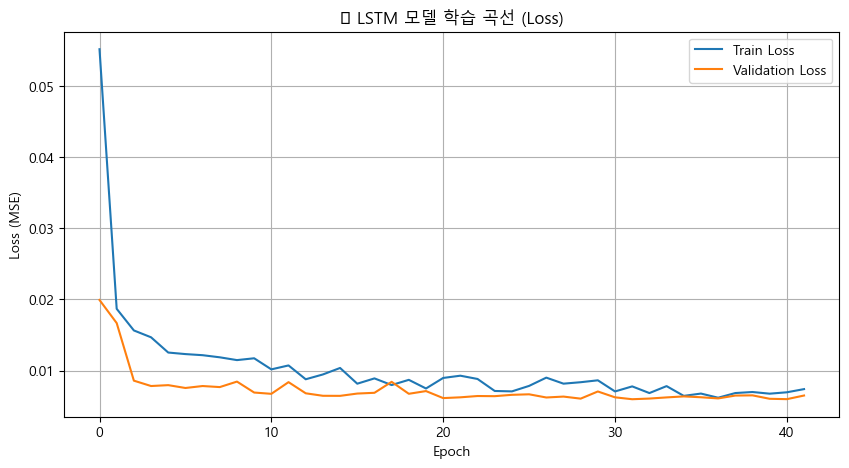

In [21]:
# ÌïôÏä¥ Í≥ºÏ†ï (Loss) ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('üîß LSTM Î™®Îç∏ ÌïôÏäµ Í≥°ÏÑ† (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# ÌïôÏäµÏù¥ Î™á Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú Î©àÏ∑ÑÎäîÏßÄ ÌôïÏù∏
actual_epochs = len(history.history['loss'])
print(f"ÌïôÏäµÏù¥ {actual_epochs}Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.")

ÌïôÏäµÏù¥ 42Î≤àÏß∏ ÏóêÌè≠ÏóêÏÑú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.


In [23]:
# Î™®Îç∏ Ï†ÄÏû•
joblib.dump(model, 'cpi_model.pkl')

['cpi_model.pkl']

In [24]:
y_pred = model.predict(X_test)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 268ms/step


In [25]:
# CPI ÏúÑÏπòÎäî 0Î≤àÏß∏ Ïó¥
#ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ï†ïÍ∑úÌôîÎêú Í∞íÏóêÏÑú ÏõêÎûò Í∞íÏúºÎ°ú ÎêòÎèåÎ¶¨Îäî (Ïó≠Ï†ïÍ∑úÌôî)
#Ï†ÑÏ≤òÎ¶¨Îêú Í∞íÏùÑ ÏõêÎûò Ïã§Ï†úÍ∞íÏúºÎ°ú
#MinMaxScaler.inverse_transform()ÏùÄ **ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤¥ (3Í∞ú Î≥ÄÏàò)**Í∞Ä ÏûàÏñ¥Ïïº ÎèôÏûë
#1Ïó¥ÏßúÎ¶¨(CPIÎßå) Îç∞Ïù¥ÌÑ∞Î•º Í∑∏ÎÉ• ÎÑ£ÏúºÎ©¥ Ïò§Î•òÍ∞Ä ÎÇòÍ±∞ÎÇò Ïù¥ÏÉÅÌïú Í≤∞Í≥ºÍ∞Ä ÎÇòÏôÄÏöî.
#Ìï¥Í≤∞ Î∞©Î≤ï: CPI + 0ÏúºÎ°ú Ï±ÑÏö¥ Í∏àÎ¶¨/ÌôòÏú® ‚Üí 3Ïó¥ Íµ¨ÏÑ± ÌõÑ Ïó≠Ï†ïÍ∑úÌôî
# Step 1: np.zeros((len(y_pred), 2))
#zeros()Îäî "0ÏúºÎ°ú Í∞ÄÎìù Ï±ÑÏõåÏ§ò!" ÎùºÎäî Ìï®ÏàòÏòàÏöî
#np.zeros((289, 2))Ïùò ÏùòÎØ∏:289Ìñâ 2Ïó¥ÏßúÎ¶¨ Î∞∞Ïó¥ÏùÑ ÎßåÎì§Í≥†,Î™®Îì† Í∞íÏùÑ 0.0ÏúºÎ°ú Ï±ÑÏö¥ Í≤É!
# Step 2: np.concatenate([...], axis=1):CPI + [Í∏àÎ¶¨=0, ÌôòÏú®=0]ÏùÑ Î∂ôÏó¨ÏÑú 3Ïó¥ÏßúÎ¶¨Î°ú ÎßåÎì≠ÎãàÎã§
#Step 3: scaler.inverse_transform(...):Ï†ïÍ∑úÌôîÎêú Í∞íÏùÑ ‚Üí ÏõêÎûò Í∞íÏúºÎ°ú ÎêòÎèåÎ†§Ï§çÎãàÎã§
'''[[Ï†ïÍ∑úÌôîÎêú_CPI1, Ï†ïÍ∑úÌôîÎêú_Í∏àÎ¶¨1, Ï†ïÍ∑úÌôîÎêú_ÌôòÏú®1],
 [Ï†ïÍ∑úÌôîÎêú_CPI2, Ï†ïÍ∑úÌôîÎêú_Í∏àÎ¶¨2, Ï†ïÍ∑úÌôîÎêú_ÌôòÏú®2],
 ... ]
 
 '''
y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), 2))], axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 2))], axis=1))[:, 0]


In [26]:


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f},R¬≤: {r2:.4f}")


MAE: 0.8835, RMSE: 1.1036,R¬≤: 0.5419


c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


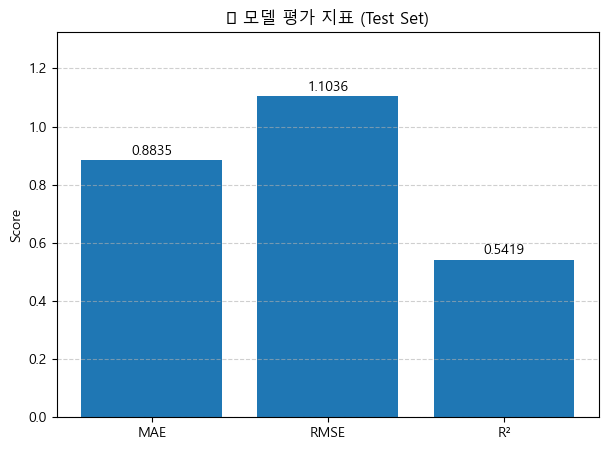

In [27]:
# ÌèâÍ∞Ä ÏßÄÌëú Í∞í Ï†ïÎ¶¨
metrics = ['MAE', 'RMSE', 'R¬≤']
values = [mae, rmse, r2]

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics, values)
plt.title('üìä Î™®Îç∏ ÌèâÍ∞Ä ÏßÄÌëú (Test Set)')
plt.ylabel('Score')
plt.ylim(0, max(values)*1.2)  # Ïó¨Ïú† Í≥µÍ∞Ñ ÌôïÎ≥¥

# Î∞î ÏúÑÏóê ÏàòÏπò ÌëúÍ∏∞
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

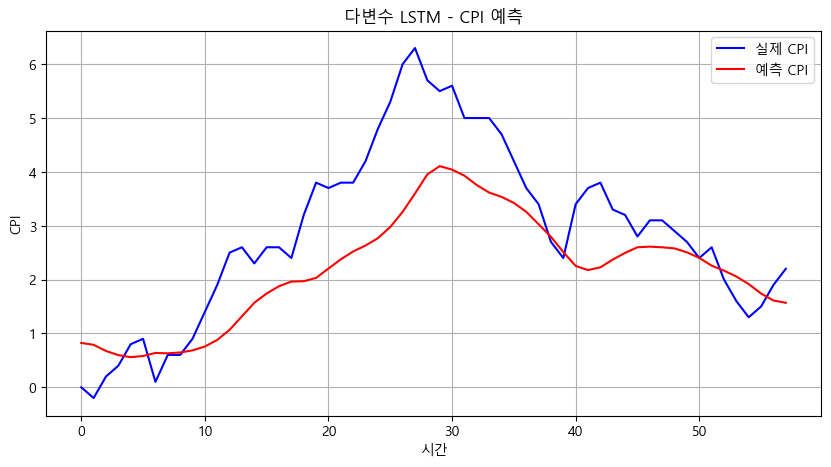

In [28]:
# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Ïã§Ï†ú CPI", color='blue')
plt.plot(y_pred_inv, label="ÏòàÏ∏° CPI", color='red')
plt.title("Îã§Î≥ÄÏàò LSTM - CPI ÏòàÏ∏°")
plt.xlabel("ÏãúÍ∞Ñ")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# cpi ÏòàÏ∏° ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù EDA


In [30]:
# 1. Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Íµ¨Ï°∞ ÌôïÏù∏
print("‚úÖ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:", merged_df.shape)
print("\nüìã Ïª¨Îüº Ï†ïÎ≥¥:")
print(merged_df.info())

# 2. Í≤∞Ï∏°Ïπò ÌôïÏù∏
print("\n‚ùì Í≤∞Ï∏°Ïπò ÌôïÏù∏:")
print(merged_df.isnull().sum())

# 3. Í∏∞Ï¥à ÌÜµÍ≥Ñ
print("\nüìä Í∏∞Ï¥à ÌÜµÍ≥Ñ ÏöîÏïΩ:")
print(merged_df.describe())

‚úÖ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (301, 4)

üìã Ïª¨Îüº Ï†ïÎ≥¥:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      301 non-null    datetime64[ns]
 1   CPI     301 non-null    float64       
 2   Í∏àÎ¶¨      301 non-null    float64       
 3   ÌôòÏú®      301 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 9.5 KB
None

‚ùì Í≤∞Ï∏°Ïπò ÌôïÏù∏:
ÎÇ†Ïßú     0
CPI    0
Í∏àÎ¶¨     0
ÌôòÏú®     0
dtype: int64

üìä Í∏∞Ï¥à ÌÜµÍ≥Ñ ÏöîÏïΩ:
                                  ÎÇ†Ïßú    CPI     Í∏àÎ¶¨      ÌôòÏú®
count                            301 301.00 301.00  301.00
mean   2012-07-01 07:34:29.102990080   2.50   3.55 1153.00
min              2000-01-01 00:00:00  -0.40   0.83  900.70
25%              2006-04-01 00:00:00   1.40   2.06 1086.30
50%              2012-07-01 00:00:00   2.50   3.46 1143.00
75%              2018-10-0

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\1422149743.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


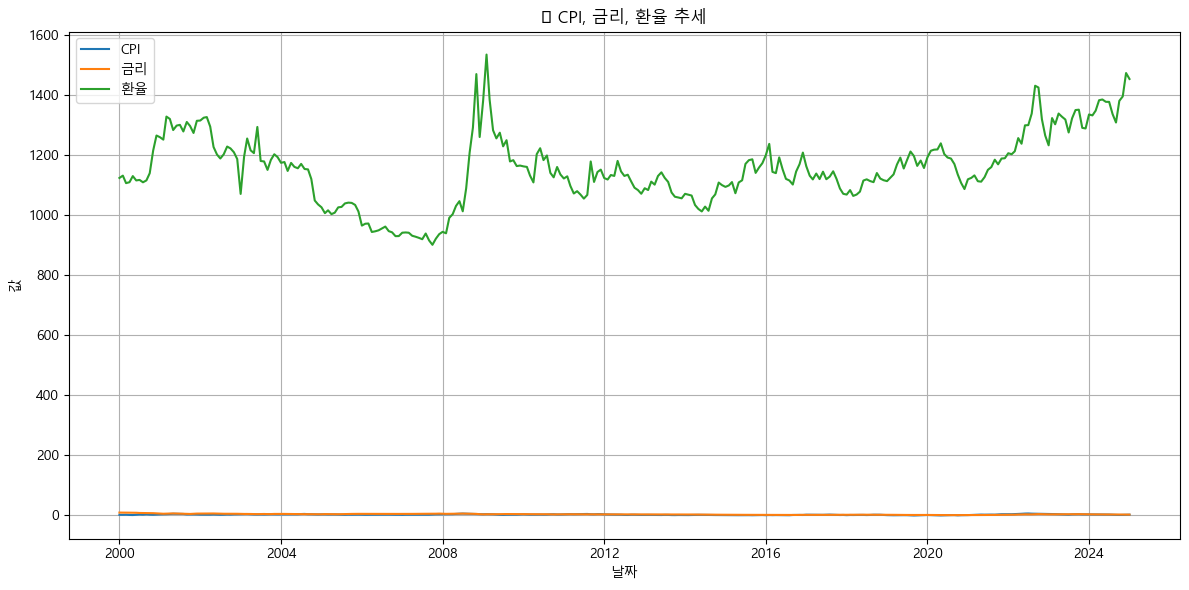

In [31]:
# ÏãúÍ≥ÑÏó¥ ÎùºÏù∏ ÌîåÎ°Ø (Ï∂îÏÑ∏ ÌôïÏù∏)
plt.figure(figsize=(12, 6))
plt.plot(merged_df["ÎÇ†Ïßú"], merged_df["CPI"], label="CPI")
plt.plot(merged_df["ÎÇ†Ïßú"], merged_df["Í∏àÎ¶¨"], label="Í∏àÎ¶¨")
plt.plot(merged_df["ÎÇ†Ïßú"], merged_df["ÌôòÏú®"], label="ÌôòÏú®")
plt.title("üìà CPI, Í∏àÎ¶¨, ÌôòÏú® Ï∂îÏÑ∏")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("Í∞í")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\3827381578.py:6: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


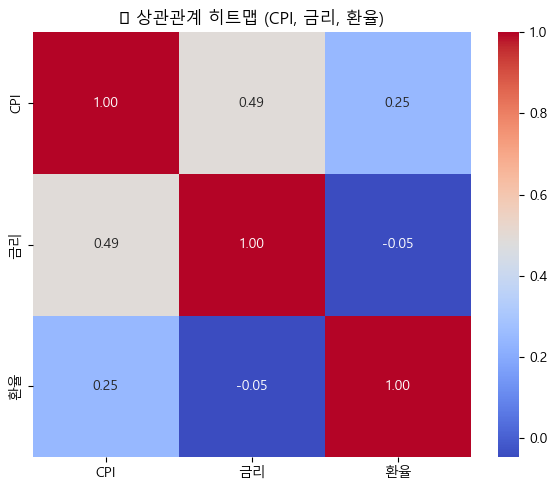

In [32]:
# Î≥ÄÏàò Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ
plt.figure(figsize=(6, 5))
corr = merged_df[["CPI", "Í∏àÎ¶¨", "ÌôòÏú®"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("üìå ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ (CPI, Í∏àÎ¶¨, ÌôòÏú®)")
plt.tight_layout()
plt.show()

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\2012984050.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


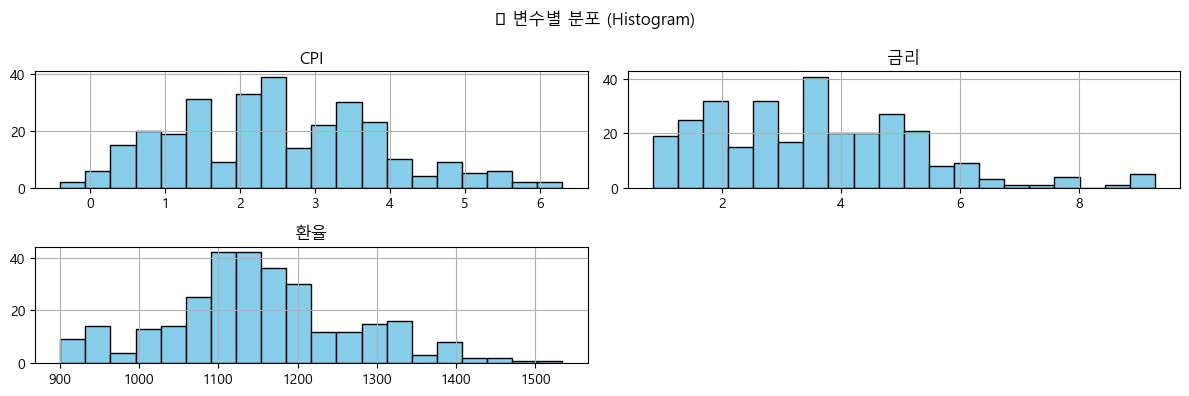

In [33]:
# Î≥ÄÏàòÎ≥Ñ Î∂ÑÌè¨ (ÌûàÏä§ÌÜ†Í∑∏Îû®)
merged_df[["CPI", "Í∏àÎ¶¨", "ÌôòÏú®"]].hist(bins=20, figsize=(12, 4), color='skyblue', edgecolor='black')
plt.suptitle("üìä Î≥ÄÏàòÎ≥Ñ Î∂ÑÌè¨ (Histogram)")
plt.tight_layout()
plt.show()

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


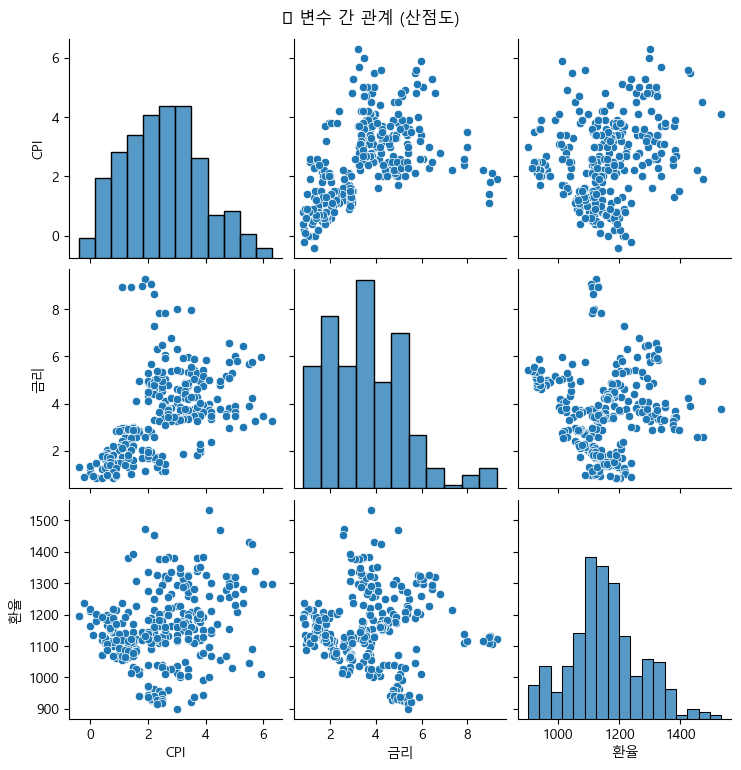

In [34]:
# Î≥ÄÏàò Í∞Ñ ÏÇ∞Ï†êÎèÑ (Scatter Plot)
sns.pairplot(merged_df[["CPI", "Í∏àÎ¶¨", "ÌôòÏú®"]])
plt.suptitle("üîç Î≥ÄÏàò Í∞Ñ Í¥ÄÍ≥Ñ (ÏÇ∞Ï†êÎèÑ)", y=1.02)
plt.show()

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


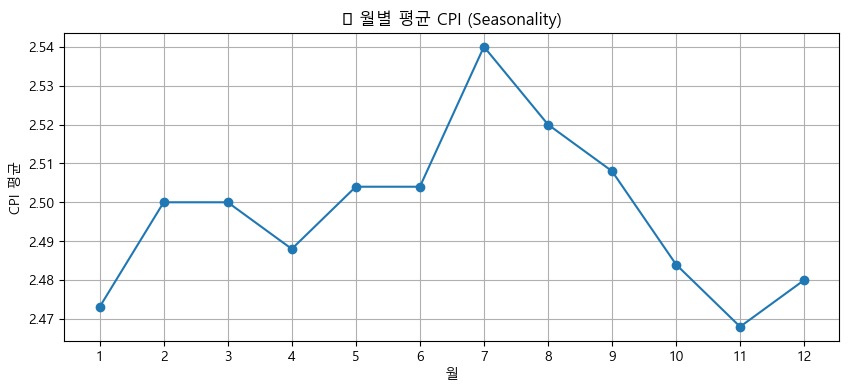

In [35]:
# ÏõîÎ≥Ñ ÌèâÍ∑† CPI Ï∂îÏÑ∏ (Seasonality ÌååÏïÖ)# 
monthly_avg = merged_df.copy()
monthly_avg["Ïó∞ÎèÑ"] = monthly_avg["ÎÇ†Ïßú"].dt.year
monthly_avg["Ïõî"] = monthly_avg["ÎÇ†Ïßú"].dt.month
monthly_cpi = monthly_avg.groupby("Ïõî")["CPI"].mean()

plt.figure(figsize=(10, 4))
plt.plot(monthly_cpi.index, monthly_cpi.values, marker='o')
plt.title("üìÜ ÏõîÎ≥Ñ ÌèâÍ∑† CPI (Seasonality)")
plt.xlabel("Ïõî")
plt.ylabel("CPI ÌèâÍ∑†")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

In [36]:
print("‚úÖ EDA ÏôÑÎ£å: Îç∞Ïù¥ÌÑ∞ Ï∂îÏÑ∏, Î∂ÑÌè¨, ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ, Í≥ÑÏ†àÏÑ± ÌôïÏù∏")

‚úÖ EDA ÏôÑÎ£å: Îç∞Ïù¥ÌÑ∞ Ï∂îÏÑ∏, Î∂ÑÌè¨, ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ, Í≥ÑÏ†àÏÑ± ÌôïÏù∏


In [39]:
  

merged_cpi_df = pd.read_csv('merged_cpi_dataset.csv', parse_dates=['ÎÇ†Ïßú'])

# ÌîÑÎ°úÌååÏùºÎßÅ Î¶¨Ìè¨Ìä∏ ÏÉùÏÑ±
profile = ProfileReport(merged_cpi_df, title="CPI ÏòàÏ∏° Î™®Îç∏Ïö© Îç∞Ïù¥ÌÑ∞ ÌîÑÎ°úÌååÏùºÎßÅ Î¶¨Ìè¨Ìä∏", explorative=True)

# HTMLÎ°ú Ï†ÄÏû•
profile.to_file("cpi_profiling_report.html")

Summarize dataset:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 8/15 [00:00<00:00, 42.06it/s, scatter Í∏àÎ¶¨, CPI]]          c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  plt.savefig(
c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.savefig(
Summarize dataset:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 9/15 [00:00<00:00, 42.06it/s, scatter CPI, Í∏àÎ¶¨]c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  plt.savefig(
c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.savefig(
Summarize dataset:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 10/15 [00:00<00:00, 42.06it/s, scatter Í∏àÎ¶¨, Í∏àÎ¶¨]c:\test\.venv

In [48]:
from ydata_profiling import ProfileReport  # ‚úÖ Î∞òÎìúÏãú ÌïÑÏöî
from streamlit_pandas_profiling import st_profile_report  # StreamlitÏóê Ï∂úÎ†•ÌïòÍ∏∞ ÏúÑÌï¥ ÌïÑÏöî
from streamlit_pandas_profiling import st_profile_report
import streamlit as st
# Î™®Îç∏ Î°úÎî©ÏùÑ Ï∫êÏã±ÌïòÏó¨ ÏÑ±Îä• ÏµúÏ†ÅÌôî
@st.cache_resource
def load_model():
    return joblib.load("cpi_model.pkl")

model = load_model()

In [49]:
# -----------------------------------------
# Î∏åÎùºÏö∞Ï†Ä ÌÉ≠Ïóê ÌëúÏãúÎê† Ï†úÎ™©ÏùÑ ÏÑ§Ï†ï

st.title("üìà CPI ÏòàÏ∏° Î™®Îç∏ ÎåÄÏãúÎ≥¥Îìú")

# -----------------------------------------
# 1. ÏÇ¨Ïö©ÏûêÎ°úÎ∂ÄÌÑ∞ Îç∞Ïù¥ÌÑ∞ ÏóÖÎ°úÎìú Î∞õÍ∏∞
st.sidebar.header("üìÇ CSV ÏóÖÎ°úÎìú")
uploaded_file = st.sidebar.file_uploader("CPI ÏòàÏ∏°Ïö© CSV ÌååÏùºÏùÑ ÏóÖÎ°úÎìúÌïòÏÑ∏Ïöî", type="csv")
# üìä Îç∞Ïù¥ÌÑ∞ ÌîÑÎ°úÌååÏùºÎßÅ Î¶¨Ìè¨Ìä∏
from ydata_profiling import ProfileReport
from streamlit_pandas_profiling import st_profile_report
# ÏÇ¨Ïö©ÏûêÍ∞Ä CSV ÌååÏùºÏùÑ ÏóÖÎ°úÎìúÌñàÏùÑ Îïå Ïã§
if uploaded_file is not None:
    # CSV ÏùΩÍ∏∞
    df = pd.read_csv(uploaded_file, parse_dates=['ÎÇ†Ïßú'])  # 'date' Ïª¨Îüº ÌïÑÏàò
    st.subheader("‚úÖ ÏóÖÎ°úÎìúÎêú ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞")
    st.dataframe(df.head())

    # -----------------------------------------
    # 2. YData Profiling Î¶¨Ìè¨Ìä∏ ÏÉùÏÑ± Î∞è Ï∂úÎ†•
    st.subheader("üìä Îç∞Ïù¥ÌÑ∞ ÌîÑÎ°úÌååÏùºÎßÅ Î¶¨Ìè¨Ìä∏")
    profile = ProfileReport(df, title="CPI Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù", explorative=True)
    st_profile_report(profile) # st_profile_report()Î•º ÌÜµÌï¥ Streamlit ÌôîÎ©¥Ïóê Ïù¥ Î¶¨Ìè¨Ìä∏Î•º ÌëúÏãúÌï©ÎãàÎã§.

    # -----------------------------------------
    # 3. CPI ÏòàÏ∏° ÏàòÌñâ
    st.subheader("üß† CPI ÏòàÏ∏° Í≤∞Í≥º")

    # ‚úÖ ÏòàÏ∏°Ïóê ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò
    feature_cols = ['CPI','Í∏àÎ¶¨', 'ÌôòÏú®']
    if all(col in df.columns for col in feature_cols):
        X = df[feature_cols].values
        y_pred = model.predict(X)

        # ‚ö†Ô∏è ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä 2Ï∞®ÏõêÏù¥ÎùºÎ©¥ 1Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôò
        if y_pred.ndim == 2:
            y_pred = y_pred.flatten()

        df['CPI_pred'] = y_pred
    else:
        st.error("‚ùå ÏòàÏ∏°Ïóê ÌïÑÏöîÌïú Ïª¨ÎüºÏù¥ ÎàÑÎùΩÎêòÏóàÏäµÎãàÎã§: " + ", ".join(feature_cols))
        st.stop()

    # -----------------------------------------
    # 4. ÏãúÍ≥ÑÏó¥ Ï∞®Ìä∏ ÏãúÍ∞ÅÌôî
    st.subheader("üìà Ïã§Ï†ú vs ÏòàÏ∏° CPI ÏãúÍ≥ÑÏó¥")
    try:
        st.line_chart(df.set_index('ÎÇ†Ïßú')[['CPI', 'CPI_pred']])
    except Exception as e:
        st.warning("ÏãúÍ≥ÑÏó¥ Ï∞®Ìä∏Î•º Í∑∏Î¶¨Îäî Ï§ë Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§.")
        st.exception(e)

    # -----------------------------------------
    # 5. ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞ Î∞è ÌëúÏãú
    st.subheader("üìå ÏòàÏ∏° ÏÑ±Îä• ÏßÄÌëú")

    mae = mean_absolute_error(df['CPI'], df['CPI_pred'])
    rmse = np.sqrt(mean_squared_error(df['CPI'], df['CPI_pred']))
    r2 = r2_score(df['CPI'], df['CPI_pred'])

    col1, col2, col3 = st.columns(3)
    col1.metric("üìâ MAE", f"{mae:.4f}")
    col2.metric("üìä RMSE", f"{rmse:.4f}")
    col3.metric("üìà R¬≤ Score", f"{r2:.4f}")
else:
    st.info("ÏôºÏ™Ω ÏÇ¨Ïù¥ÎìúÎ∞îÏóêÏÑú CSV ÌååÏùºÏùÑ ÏóÖÎ°úÎìúÌïòÎ©¥ Î∂ÑÏÑù Í≤∞Í≥ºÍ∞Ä ÌëúÏãúÎê©ÎãàÎã§.")

2025-03-25 17:30:08.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-03-25 17:30:08.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
